# Implementing a Simple Classifier of letters using Numpy

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
data=pd.read_csv("/Users/TT/Downloads/emnist-letters-train.csv")
data.head()

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our training dataset is ~ 87k grayscale images of shape 28 * 28 

when we loaded the csv we had 785 columns for 28 * 28 pixels and 1 for the labels, so we will transform the data to obain the examples as the columns, the pixels in the rows, as well as a seperate vector for the labels Y

In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_test = data_dev[0]
X_test = data_dev[1:n]
X_test = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape
X_train.shape

(784, 87799)

In [3]:
#Mapping label number to letter
Mapping={
1:'A',
2:'B',
3:'C',
4:'D',
5:'E',
6:'F',
7:'G',
8:'H',
9:'I',
10:'J',
11	:'K',
12:	'L',
13	:'M',
14	:'N',
15:	'O',
16:	'P',
17	:'Q',
18	:'R',
19	:'S',
20	:'T',
21	:'U',
22	:'V',
23	:'W',
24	:'X',
25:'Y',
26	:'Z'}

We initialize the parameters of the hidden layer to take 784 inputs in 61 neurons. 
Knowing that n=number of examples and m= number of inputs(pixels), X_train’s shape is (mxn), so the matrix of weights of the hidden layer w1’ s shape should be (number of neurons x m).
Using a random function that will give us numbers between 0 and 1 and subtracting by 0.5 will give us equally positive and negative numbers.
The second matrix of weights(output layer)’s shape is (number of outputs from the hidden layer x number of final outputs), thus (2x61).
I also created a bias for each neuron.

In [4]:
def init_params():
    W1 = np.random.rand(27, 784) - 0.5
    b1 = np.random.rand(27, 1) - 0.5
    W2 = np.random.rand(27, 27) - 0.5
    b2 = np.random.rand(27, 1) - 0.5
    return W1, b1, W2, b2

In [5]:
def ReLU(Z):
    return np.maximum(Z, 0)

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def sigmoid_der(x):
    return x*(1.0 - x)

def ReLU_deriv(Z):
    return Z > 0

In the forward function I will return the output of each layer before and after the activation function.
Z1 and A1 will have the shape (61,115322),
While Z2 and A2 will have the shape (2,115322) 

In [6]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

The first row of the data matrix was the label so we put that into a vector called Y_train but we want to dummy encode the result in a matrix.
This function creates an array filled with zeros with:
The number of rows = the number of examples. 
The number of columns = the maximum label+1 to account for 0.
Then I iterate through each row and replace 0 by 1 on the corresponding column. Then I transpose the matrix so that one_hot_Y has 2 rows the same as the output A2. 

In [7]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

After dummy encoding the desired value vector, I can obtain the error value of the output layer which is done simply by subtracting output-desired, then I append the average cost to a list to plot later. I tried multiplying with the sigmoid derivative of A2 but that slowed the learning of the model.
To adjust the weights of the output layer I multiplied the error matrix by the output matrix of the first layer transposed and normalized by dividing by the number of examples. Not normalizing results in a overflow warning with the exp() function because it can’t handle such big numbers and would cause the accuracy to decrease.

In [8]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y,costs):
    one_hot_Y= one_hot(Y)
    dZ2 = A2 - one_hot_Y
    costs.append(np.mean(abs(dZ2)))
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2,costs

To calculate the ‘error’ of the hidden layer I multiplied the weights of the output layer transposed (before adjusting) with the error matrix and then multiplied by the ReLu derivative of the output of the hidden layer.
To adjust the weights of the hidden layer I multiplied the error I just calculated with the input matrix transposed and normalized the matrix.
To adjust the bias I computed the average of the errors at each layer.
Then I returned the adjustment matrices and the list of the costs

In [9]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [10]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


To put everything together, first I initialized the parameters and the costs list, then for a fixed amount of iterations I did one forward, one backward and one update to the parameters. Then for each 100 iterations I printed the output A2 (the maximum output out of 27 neurons) and the accuracy. 

In [11]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    costs=[]
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2,costs = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y,costs)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2,costs

In [12]:
W1, b1, W2, b2,costs = gradient_descent(X_train, Y_train, 0.10, 1501)

Iteration:  0
[ 6 10  6 ... 10  5  5] [10 14  6 ...  1 22 13]
0.03763140810259798
Iteration:  100
[22 10  6 ...  9  5 23] [10 14  6 ...  1 22 13]
0.23349924258818439
Iteration:  200
[22  4  6 ...  4 14 23] [10 14  6 ...  1 22 13]
0.37572181915511565
Iteration:  300
[26  8  6 ...  4 14 13] [10 14  6 ...  1 22 13]
0.4553013132268021
Iteration:  400
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.5028872766204626
Iteration:  500
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.5353933416098133
Iteration:  600
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.5596532990125173
Iteration:  700
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.57967630610827
Iteration:  800
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.5962254695383774
Iteration:  900
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.6093919065137416
Iteration:  1000
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.6205309855465324
Iteration:  1100
[10  8  6 ... 24 14 13] [10 14  6 ...  1 22 13]
0.6309980751489197
Ite

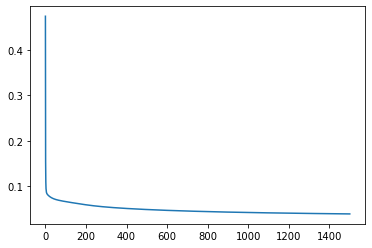

In [13]:
plt.plot(costs)
plt.show()

I defined a function to make a prediction for a specific index in X_test (the test array). We remember that each column on our array consists of an example so store that image in the variable current_image then we run one forward iteration using the prediction function. After that we reshape that image and bring it back to a 255 scale so we can plot it, we print the label and the prediction as well. 


In [14]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2,Mapping,X_dev,Y_dev):
    current_image = X_dev[:, index, None]
    prediction = make_predictions(X_dev[:, index, None], W1, b1, W2, b2)
    label = Y_dev[index]
    print("Prediction: ", Mapping[prediction[0]])
    print("Label: ", Mapping[label])
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  Y
Label:  Y


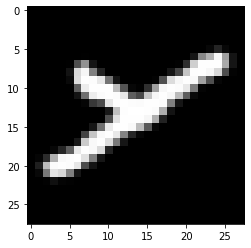

In [15]:
test_prediction(89, W1, b1, W2, b2,Mapping,X_dev,Y_dev)

Prediction:  Z
Label:  Z


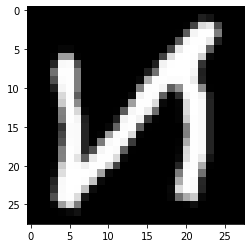

In [16]:
test_prediction(5, W1, b1, W2, b2,Mapping,X_dev,Y_dev)

Prediction:  E
Label:  E


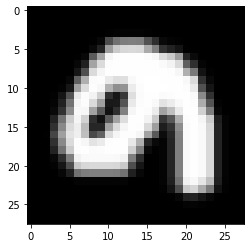

In [17]:
test_prediction(90, W1, b1, W2, b2,Mapping,X_dev,Y_dev)

Prediction:  W
Label:  F


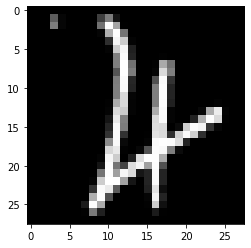

In [18]:
test_prediction(2, W1, b1, W2, b2,Mapping,X_dev,Y_dev)

Prediction:  P
Label:  P


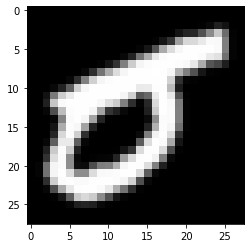

In [19]:
test_prediction(615, W1, b1, W2, b2,Mapping,X_dev,Y_dev)